# Regression Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Read CSV and clean the DataFrame

In [2]:
def dummyEncode(df):
    columnsToEncode = list(df.select_dtypes(include=['category', 'object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding: ' +feature)
    return df

In [3]:
# Read in CSV
ames_housing_data_url = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv'
housing_df = pd.read_csv(ames_housing_data_url)

# Drop 5 features with the highest NaN count and `Id`
housing_df = housing_df.drop(columns=['PoolQC', 'MiscFeature', 
                                      'Alley', 'Fence', 'FireplaceQu', 'Id'])

# Encode non-numeric features using sklearn.preprocessing.LabelEncoder
non_numeric = housing_df.select_dtypes(exclude='number').columns
non_numeric_encoded = dummyEncode(housing_df[non_numeric].copy())
housing_df[non_numeric] = non_numeric_encoded

# Validate type casting
housing_df.dtypes.value_counts()

Error encoding: MasVnrType
Error encoding: BsmtQual
Error encoding: BsmtCond
Error encoding: BsmtExposure
Error encoding: BsmtFinType1
Error encoding: BsmtFinType2
Error encoding: Electrical
Error encoding: GarageType
Error encoding: GarageFinish
Error encoding: GarageQual
Error encoding: GarageCond


int64      34
int32      27
object     11
float64     3
dtype: int64

## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

In [4]:
# Sort features with the highest correlation coefficients with regard to the target variable
target = 'SalePrice'
features = housing_df.corr()['SalePrice']\
            .sort_values(ascending=False)\
            .index[1:15]\
            .tolist()

# Check for NaNs in selected features
housing_df[features].isna().sum()

OverallQual      0
GrLivArea        0
GarageCars       0
GarageArea       0
TotalBsmtSF      0
1stFlrSF         0
FullBath         0
TotRmsAbvGrd     0
YearBuilt        0
YearRemodAdd     0
GarageYrBlt     81
MasVnrArea       8
Fireplaces       0
BsmtFinSF1       0
dtype: int64

In [5]:
# Impute missing observations
housing_df[['GarageYrBlt', 'MasVnrArea']] = \
housing_df[['GarageYrBlt', 'MasVnrArea']].ffill()

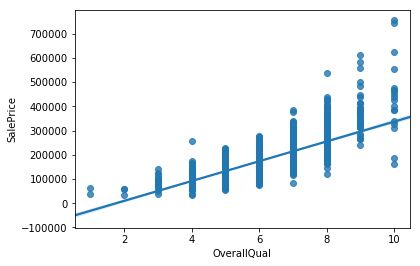

In [6]:
X = housing_df[features[0]]    # 'OverallQual'
y = housing_df[target]

# robust, if True, uses statsmodel linear regression and deweights outliers 
sns.regplot(data=housing_df, x=X, y=y, robust=True, ci=95, n_boot=500);

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

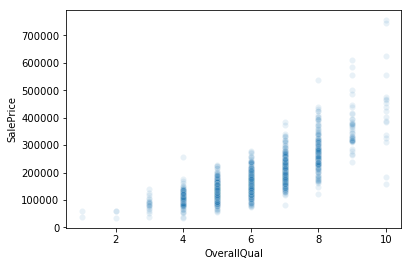

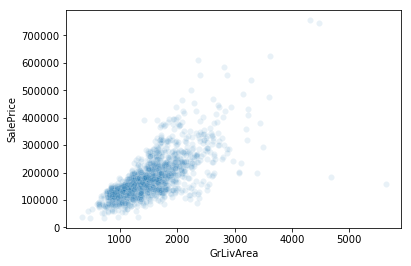

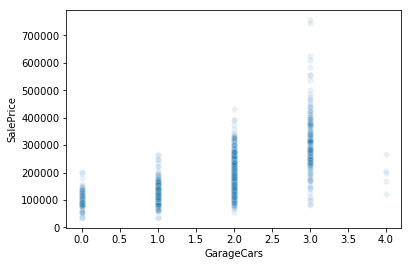

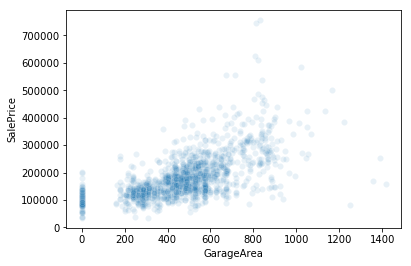

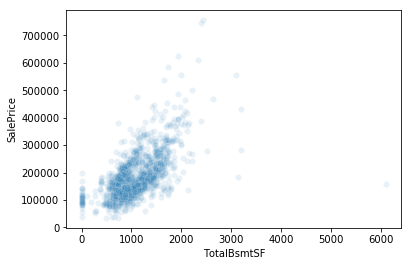

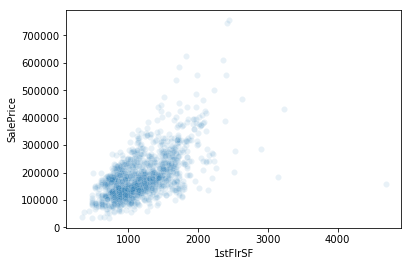

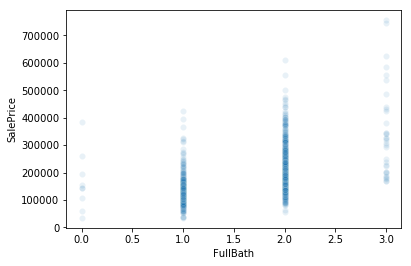

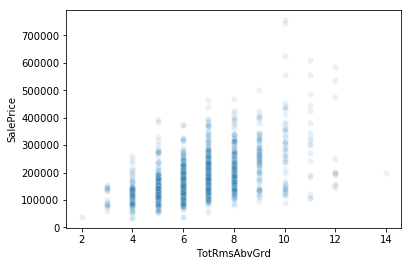

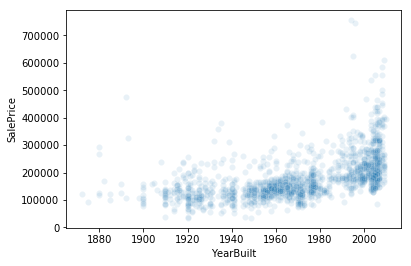

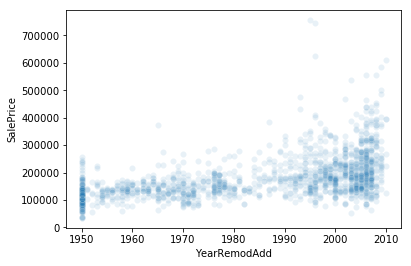

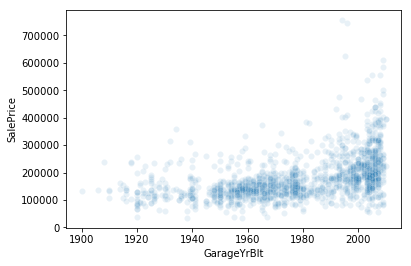

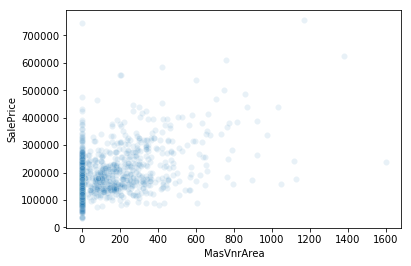

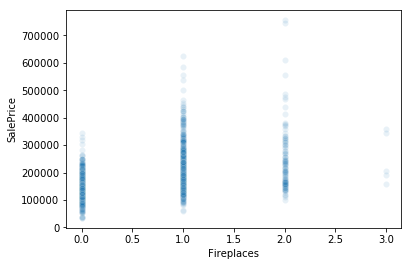

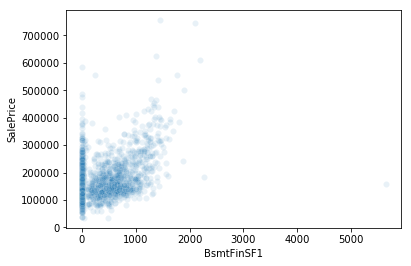

In [7]:
for feature in features:
    sns.scatterplot(x=feature, y=target, data=housing_df, alpha=0.1)
    plt.show()

In [8]:
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', '1stFlrSF', 'FullBath',
            'TotRmsAbvGrd', 'YearBuilt']

X = housing_df[features]
y = housing_df[target]

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     597.6
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        18:46:29   Log-Likelihood:                -17480.
No. Observations:                1460   AIC:                         3.498e+04
Df Residuals:                    1451   BIC:                         3.503e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -8.273e+05   9.07e+04     -9.119   

D:\Miniconda\envs\JupyterLab\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

I see that OverallQual, GarageCars, FullBath, and TotRmsAbvGrd have very high standard errors (and const too). I suspect that Ordinary Least Squares regression isn't able to extract much in terms of explained variance of the target variable when the according features only express a small number of possibilities, and are likely to have a significant quantity of outliers. 

As for the p-values of the coefficients, some are indicative of not being useful for this model. The null hypothesis for coefficient p-values is such that the coefficient is 0, having no effect. P-values in the range of p < 0.05 can be interpreted as statistically significant meaning that the values of the coefficients are related to the values of the target variable.

## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [9]:
print('Old housing_df shape: ', housing_df.shape)
housing_df = housing_df[(np.abs(stats.zscore(housing_df[features]) < 3).all(axis=1))]
print('After removing outliers: ', housing_df.shape)

Old housing_df shape:  (1460, 75)
After removing outliers:  (1423, 75)


The biggest changes occured in `GarageCars`, `FullBath`, and `TotRmsAbvGrd`.

In [10]:
X = housing_df[features] 
y = housing_df[target]
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     760.5
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        18:46:29   Log-Likelihood:                -16705.
No. Observations:                1423   AIC:                         3.343e+04
Df Residuals:                    1414   BIC:                         3.348e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.345e+05   7.39e+04    -12.641   

## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

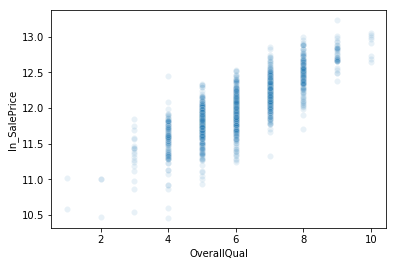

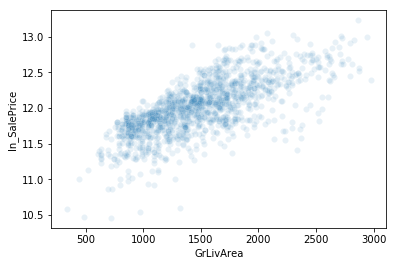

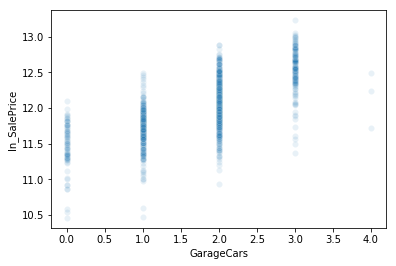

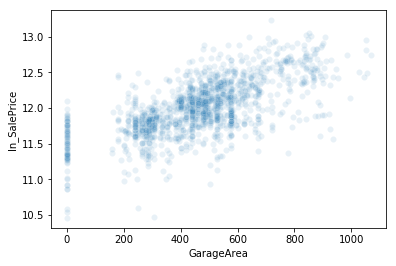

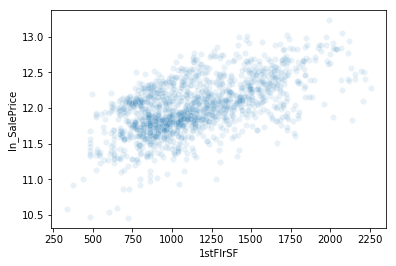

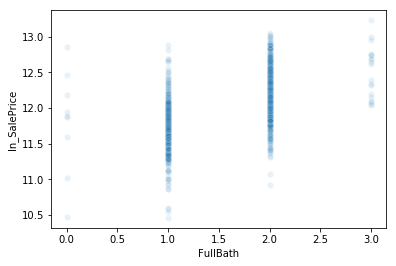

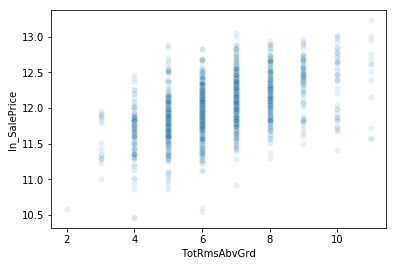

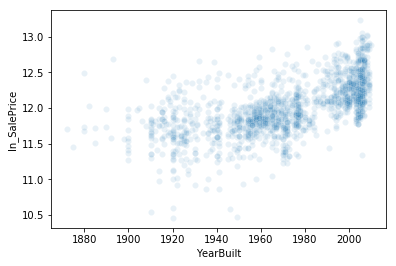

In [11]:
housing_df['ln_SalePrice'] = np.log(housing_df['SalePrice'])
housing_df = housing_df.drop(columns='SalePrice')

# First, graph transformed relationships to get some visual intuition.
target = 'ln_SalePrice'
for feature in features:
    sns.scatterplot(data=housing_df, x=feature, y=target, alpha=0.1)
    plt.show()

In [12]:
# Log-Linear Regression
X = housing_df[features]
y = housing_df[target]

model = sm.OLS(y, sm.add_constant(X))
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:           ln_SalePrice   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     863.4
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        18:46:33   Log-Likelihood:                 610.72
No. Observations:                1423   AIC:                            -1203.
Df Residuals:                    1414   BIC:                            -1156.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.0219      0.384     13.083   

## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [13]:
# Calculate Variance Inflation Factor
# Consider X variables with VIF > 10 for dropping
# const value can/should be high or infinite.
X = sm.add_constant(X)
vif = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
pd.Series(vif, X.columns)

const           8394.530684
OverallQual        2.402348
GrLivArea          4.564351
GarageCars         5.426749
GarageArea         4.972600
1stFlrSF           1.459929
FullBath           2.095338
TotRmsAbvGrd       3.194458
YearBuilt          2.079491
dtype: float64

There are no features with a VIF greater than 10. `GarageCars` is the highest at 5.426.

## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

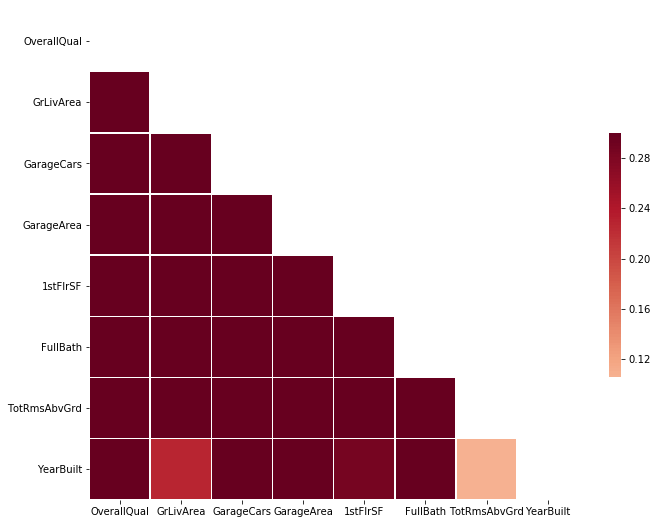

In [14]:
# Compute correlation matrix
features_corr = housing_df[features].corr()

# Generate mask for the upper triangle
mask = np.zeros_like(features_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Draw heatmap with mask and correct aspect ratio
sns.heatmap(features_corr, mask=mask, cmap='RdBu_r',
            vmax=0.3, center=0, square=True,
            linewidths=0.5, cbar_kws={'shrink':0.5});

## 2.3 If you have variables with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

In the cell below I drop `GarageCars`, but maybe because its VIF isn't very high the resulting R-squared value doesn't change and the Jarque-Bera score actually increases.

In [15]:
# Drop 'GarageCars'
target = 'ln_SalePrice'
features = ['OverallQual', 'GrLivArea', 'GarageArea', '1stFlrSF',
            'FullBath', 'TotRmsAbvGrd', 'YearBuilt']

X = housing_df[features]
y = housing_df[target]
X = sm.add_constant(X)
model = sm.OLS(y, X)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:           ln_SalePrice   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     984.2
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        18:46:34   Log-Likelihood:                 608.81
No. Observations:                1423   AIC:                            -1202.
Df Residuals:                    1415   BIC:                            -1160.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.8976      0.379     12.927   

## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

In [16]:
# Log-linear regression with robust standard errors
# Robust standard error corrects for heteroskedasticity

# X, y are unchanged
model = sm.OLS(y, X)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_SalePrice   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     841.0
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        18:46:34   Log-Likelihood:                 608.81
No. Observations:                1423   AIC:                            -1202.
Df Residuals:                    1415   BIC:                            -1160.
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.8976      0.425     11.513   

## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

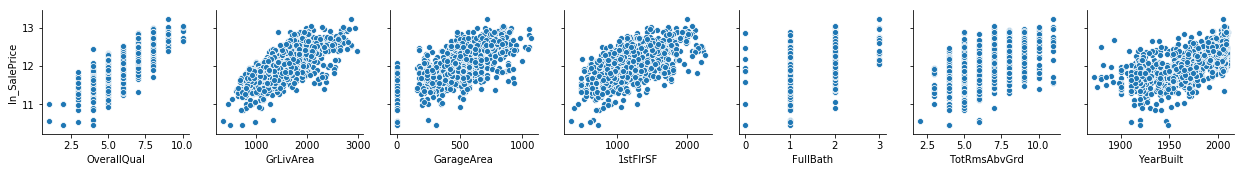

In [17]:
# Plot for initial inspection
sns.pairplot(data=housing_df, x_vars=features, y_vars=target);

## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

D:\Miniconda\envs\JupyterLab\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
D:\Miniconda\envs\JupyterLab\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


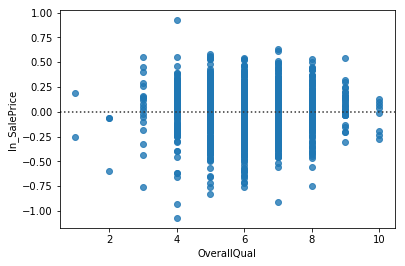

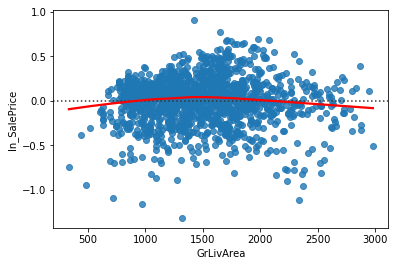

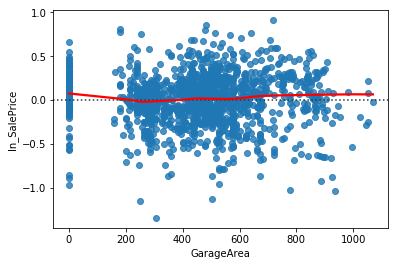

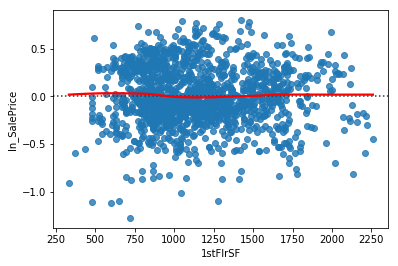

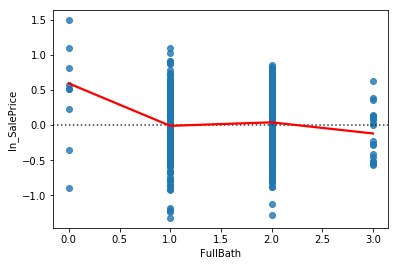

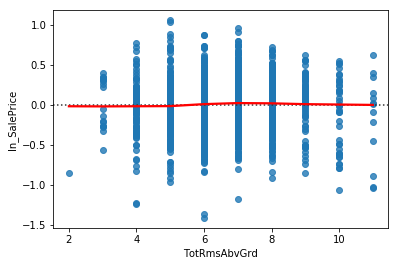

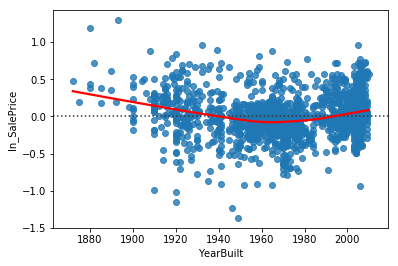

In [18]:
for feature in features:
    sns.residplot(data=housing_df, x=feature, y=target, lowess=True, line_kws=dict(color='r'))
    plt.show()

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

In [19]:
# Possible polynomial features:
housing_df['squared_YearBuilt'] = housing_df['YearBuilt']**2
housing_df['squared_GrLivArea'] = housing_df['GrLivArea']**2
housing_df['squared_GarageArea'] = housing_df['GarageArea']**2

features.extend(['squared_YearBuilt', 'squared_GrLivArea', 'squared_GarageArea'])

# Log-polynomial multiple regression with robust standard error
X = housing_df[features]
y = housing_df[target]

model = sm.OLS(y, sm.add_constant(X))
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_SalePrice   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     631.2
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        18:46:40   Log-Likelihood:                 611.99
No. Observations:                1423   AIC:                            -1202.
Df Residuals:                    1412   BIC:                            -1144.
Df Model:                          10                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -17.2258     22

### Comparison

To me the first linear regression with statsmodel had coefficients that were easier to interpret. The y variable was not normalized, robust standard error was not used, and there were no polynomial features. On the other hand, I was only able to achieve a higher R-squared statistic and lower Jarque-Bera statistic by employing all of those techniques. The tradeoff is very clear: a simpler model may have less predictive power and be easier to interpret, but a highly engineered feature set and complex linear regression will have much better predictive accuracy at the cost of having beta coefficients that are difficult to interpret.

# Stretch Goals

- Research the assumptions that are required for OLS to be BLUE the "Best Linear Unbiased Estimator". You might try searching and trying to understand the conditions of what's called the Gauss-Markov Theorem.
- Research other diagnostic tests. Can you show that residuals are normally distributed graphically?
- Write a blog post about inferential modeling using linear regression.